# <center> Homework 3 -  Deep Reinforcement  Learning </center>

## <center>Edoardo Antonaci 1234431</center>

In [1]:
!pip install gym
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downl

# **1) Optimization the Cartpole**

## Library

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

import warnings
warnings.filterwarnings("ignore")

## Display and video

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

## show videos wrap enviroment

In [5]:

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable) #https://github.com/openai/gym/blob/master/gym/wrappers/monitor.py
  return env

## Experience replay (Replay Memory)

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## DQN linear

In [7]:
class DQN_linear(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

# **Exploration Policy**

### Epsilon-greedy policy


In [8]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

In [9]:
def choose_action_softmax(net, state, temperature,linear):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    if linear==True:
      softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
    if linear==False:
      softmax_out = nn.functional.softmax(net_out[0] / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

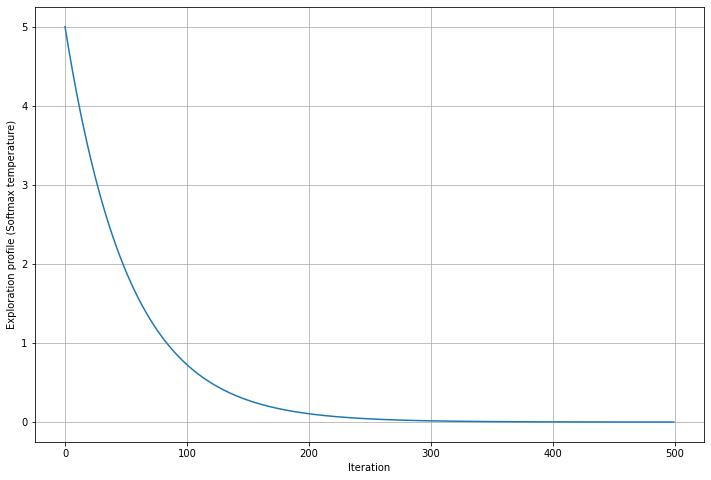

In [10]:
### Define exploration profile
initial_value = 5
num_iterations = 500
exp_decay = np.exp(-np.log(initial_value) / num_iterations *6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

## Gym CartPole-v1 Environment

In [11]:
#define enviroment
env = gym.make('CartPole-v1') # Initialize the Gym environment  https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env.seed(0) # Set a random seed for the environment (reproducible results)

[0]

## **Network update**

## parameters

In [12]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 7e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 100   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

## initialization

In [13]:
#state and action space
state_space_dim = 4
action_space_dim = env.action_space.n

In [14]:

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN_linear(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN_linear(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [15]:
def update_step_linear(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)   #as shown Q-value function part in Lab 07
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## **Training loop linear Cartpole**

In [16]:

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

scores=[] #to plot scores

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau,linear=True)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      ###################REWARD#########################################

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1.2
      reward = reward - pos_weight * np.abs(state[0]) 
      
      ####################################################################
      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step_linear(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)


      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

    scores.append(score)

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.628278073893113
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 3.81542607692074
EPISODE: 16 - FINAL SCORE

Text(0, 0.5, 'Scores')

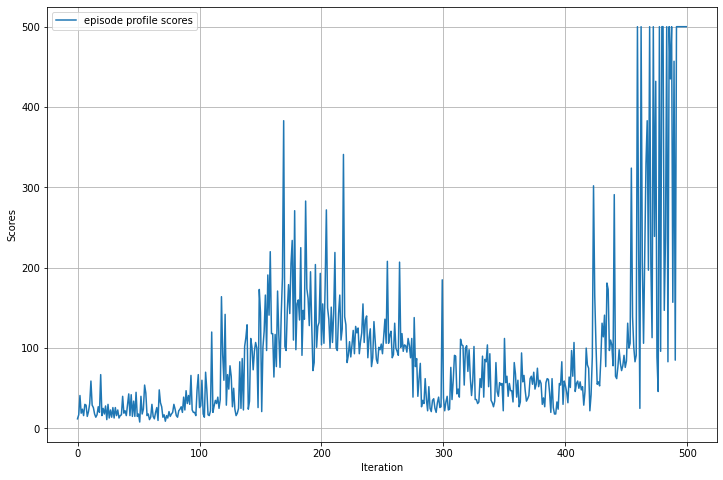

In [17]:
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(scores, label='episode profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## Final test

In [18]:

env = gym.make('CartPole-v1') # Initialize the Gym environment  https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env.seed(0) # Set a random seed for the environment (reproducible results)

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0,linear=True)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [19]:
# Display the videos, not required outside Colab
show_videos() #if black screen reload notebook


SHOWING VIDEO video/openaigym.video.1.103.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000001.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000002.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000003.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000004.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000005.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000006.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000007.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000008.mp4



SHOWING VIDEO video/openaigym.video.1.103.video000009.mp4


# **2) Control the CartPole environment**

## Resize images

In [20]:
def cropping(img):
    img=img[170:320,0:600,1]    #images 150x600
    img = torch.tensor(img.copy(), dtype=torch.float32)
    img= img.unsqueeze(0) 
    return img

Original image : 
 (400, 600, 3)


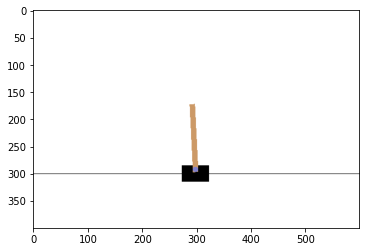

New image : 
 torch.Size([1, 150, 600])


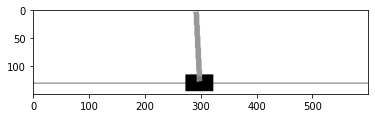

In [21]:
#Test image rescaling

state = env.reset()

#original image
img= env.render(mode='rgb_array')
print("Original image : \n",img.shape)
plt.imshow(img.squeeze())
plt.show()

#reshape one
crop_img=cropping(img)
print("New image : \n",crop_img.shape)
plt.imshow(crop_img.cpu().squeeze().numpy(),cmap='gray')
plt.show()

env.close()


## DQN convolutional

In [22]:
class DQN_conv(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()
        
        self.conv_net = nn.Sequential(
            # Size = 1x150x600
            nn.Conv2d(in_channels = channels, out_channels = 4, kernel_size = 10, stride = 10, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(15*60*4, 100),
            nn.Tanh(),
            nn.Linear(100, action_space_dim)
            )
        

    def forward(self, x):
      return self.conv_net(x)

## initialization DQN convolutional

In [23]:
channels = 1 

### Initialize the replay memory
replay_mem_conv = ReplayMemory(replay_memory_capacity) 

### Initialize the policy network
policy_net_conv = DQN_conv(channels, action_space_dim) #CNN

### Initialize the target network with the same weights of the policy network
target_net_conv = DQN_conv(channels, action_space_dim)#CNN

target_net_conv.load_state_dict(policy_net_conv.state_dict()) # This will copy the weights of the policy network to the target network


### Initialize the optimizer
optimizer_conv = torch.optim.SGD(policy_net_conv.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn_conv = nn.SmoothL1Loss()

## Update step convolutional

In [24]:
def update_step_convolutional(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)


    # Create tensors for each element of the batch
    states      = torch.stack([s[0][0] for s in batch]) #CNN
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.stack([s[2][0] for s in batch if s[2] is not None]) #CNN
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)   #as shown Q-value function part in Lab 07
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## **Training loop convolutional**

In [25]:
scores=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    img= env.render(mode='rgb_array')
    crop_img=cropping(img)
    crop_img=crop_img.unsqueeze(0) #cnn

    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net_conv, crop_img, temperature=tau,linear=False)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        ##### We apply a (linear) penalty when the cart is far from center
        pos_weight = 1.2
        reward = reward - pos_weight * np.abs(state[0]) 

        ########################
        

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_state_Pixel=None
            
        if type(next_state)!="NoneType":
            next_state_Pixel= env.render(mode='rgb_array')
            next_state_Pixel = cropping(next_state_Pixel)
            next_state_Pixel=next_state_Pixel.unsqueeze(0) #cnn
            

        # Update the replay memory
        replay_mem_conv.push(crop_img, action, next_state_Pixel, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step_convolutional(policy_net_conv, target_net_conv, replay_mem_conv, gamma, optimizer_conv, loss_fn_conv, batch_size)


        # Set the current state for the next iteration
        state = next_state
        crop_img=next_state_Pixel

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net_conv.load_state_dict(policy_net_conv.state_dict()) # This will copy the weights of the policy network to the target network
        
       

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    
    scores.append(score)

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 17 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 14 - Temperature: 4.904360255437023
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 4.8105499030220615
EPISODE: 4 - FINAL SCORE: 15 - Temperature: 4.718533950235565
EPISODE: 5 - FINAL SCORE: 45 - Temperature: 4.628278073893113
EPISODE: 6 - FINAL SCORE: 11 - Temperature: 4.539748607342401
EPISODE: 7 - FINAL SCORE: 39 - Temperature: 4.45291252790513
EPISODE: 8 - FINAL SCORE: 12 - Temperature: 4.367737444559105
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 4.2841915858559485
EPISODE: 10 - FINAL SCORE: 34 - Temperature: 4.202243788069925
Updating target network...
EPISODE: 11 - FINAL SCORE: 20 - Temperature: 4.121863483573453
EPISODE: 12 - FINAL SCORE: 25 - Temperature: 4.043020689434968
EPISODE: 13 - FINAL SCORE: 15 - Temperature: 3.96568599623489
EPISODE: 14 - FINAL SCORE: 25 - Temperature: 3.889830557095515
EPISODE: 15 - FINAL SCORE: 14 - Temperature: 3.81542607692074
EPISODE: 16 - FINAL SCORE

Text(0, 0.5, 'Scores')

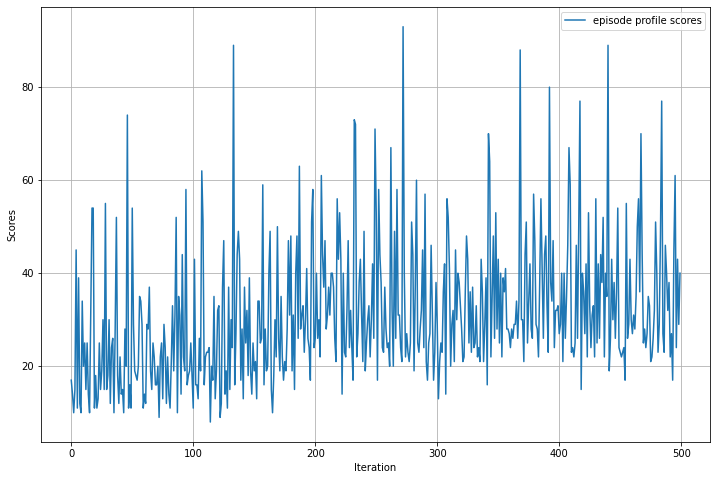

In [26]:
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(scores, label='episode profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## Test covolutional

In [27]:

env = gym.make('CartPole-v1') # Initialize the Gym environment  https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env.seed(0) # Set a random seed for the environment (reproducible results

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    img= env.render(mode='rgb_array')
    crop_img=cropping(img)
    crop_img=crop_img.unsqueeze(0) #cnn
    #img=torch.flatten(img)#fc
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        #print(img.shape)
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net_conv, crop_img, temperature=0,linear=False)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        
        if done: # if the pole has fallen down
            next_state = None
            next_state_Pixel=None
        if type(next_state)!="NoneType":
            next_state_Pixel= env.render(mode='rgb_array')
            next_state_Pixel = cropping(next_state_Pixel)
            next_state_Pixel=next_state_Pixel.unsqueeze(0) #cnn
            
        state = next_state
        crop_img=next_state_Pixel
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 10.0
EPISODE 2 - FINAL SCORE: 9.0
EPISODE 3 - FINAL SCORE: 8.0
EPISODE 4 - FINAL SCORE: 11.0
EPISODE 5 - FINAL SCORE: 8.0
EPISODE 6 - FINAL SCORE: 9.0
EPISODE 7 - FINAL SCORE: 10.0
EPISODE 8 - FINAL SCORE: 9.0
EPISODE 9 - FINAL SCORE: 9.0
EPISODE 10 - FINAL SCORE: 9.0


In [28]:
# Display the videos, not required outside Colab
show_videos()    #if black screen reload notebook


SHOWING VIDEO video/openaigym.video.2.103.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.103.video000009.mp4


# **3) MountainCar-v0 gym environment**

In [29]:
#define enviroment
env = gym.make('MountainCar-v0') # Initialize the Gym environment  https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env.seed(1)

[1]

## exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

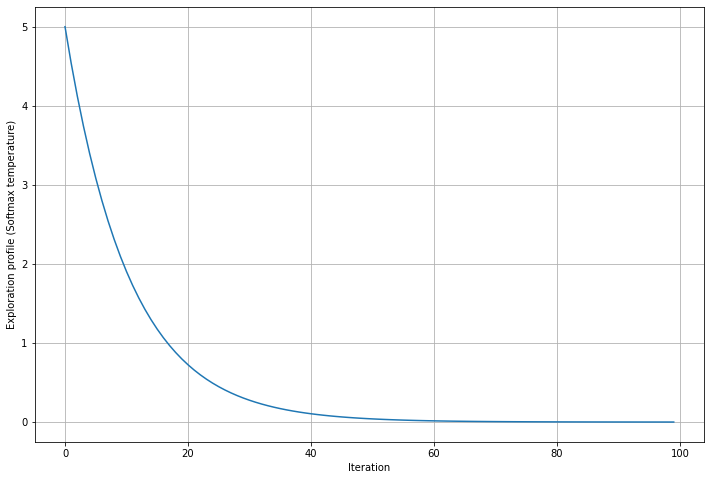

In [30]:
### Define exploration profile
initial_value = 5
num_iterations = 100
exp_decay = np.exp(-np.log(initial_value) / num_iterations *6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

## initialitation network

In [31]:
action_space_dim = env.action_space.n
state_space_dim = 2

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity) 

### Initialize the policy network
policy_net = DQN_linear(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN_linear(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## **training loop mountain-car**

In [32]:

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

positions=[] #to plot scores

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()

    position = state[0]
    # Reset the score. The final score will be the total amount of steps before the car reach the top
    score = 0
    done = False

    # Go on until the pole falls off
    while not done or score <= 200:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau,linear=True)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      ###################REWARD#########################################

      # We apply a (linear) penalty 
      pos_weight = 4
      
      if (action ==0 and state[1]<0) or (action==2 and state[1]>0):
        reward= reward + pos_weight * np.abs(state[0])
      else:reward= reward                                              
      
      ####################################################################
      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: #if car reach the top of the hill
          break

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step_linear(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Set the current state for the next iteration
      state = next_state

      position=state[0]

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - Final Position: {position}  - Temperature: {tau}") # Print the final score

    positions.append(position)

env.close()

Updating target network...
EPISODE: 1 - Final Position: -0.4393108264672219  - Temperature: 5.0
EPISODE: 2 - Final Position: -0.6739841561214328  - Temperature: 4.539748607342401
EPISODE: 3 - Final Position: -0.2280704177604605  - Temperature: 4.121863483573453
EPISODE: 4 - Final Position: -0.33676908457593735  - Temperature: 3.7424448018416157
EPISODE: 5 - Final Position: -0.6258948153271401  - Temperature: 3.3979517154432557
EPISODE: 6 - Final Position: -0.47812209701202946  - Temperature: 3.0851693136000478
EPISODE: 7 - Final Position: -0.38686176831666375  - Temperature: 2.801178618966266
EPISODE: 8 - Final Position: -0.48924931330641525  - Temperature: 2.5433293468738825
EPISODE: 9 - Final Position: -0.5248080654157873  - Temperature: 2.309215172096753
EPISODE: 10 - Final Position: -0.6748801716694064  - Temperature: 2.096651272316035
Updating target network...
EPISODE: 11 - Final Position: -0.4485330843155625  - Temperature: 1.9036539387158786
EPISODE: 12 - Final Position: -0.741

Text(0, 0.5, 'Positions')

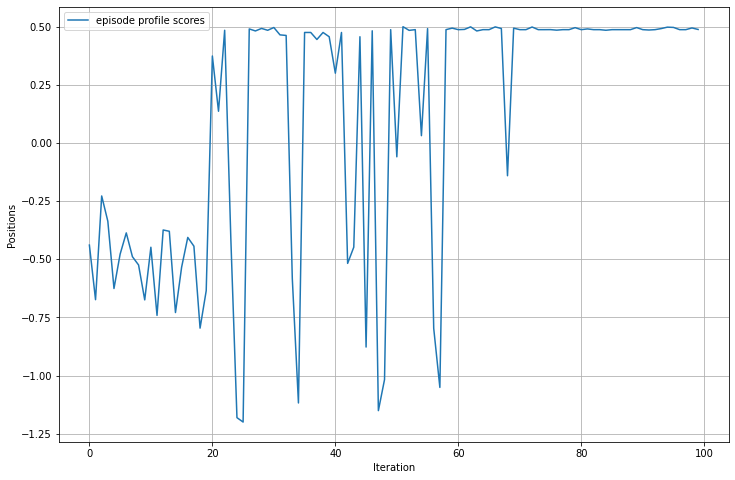

In [33]:
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(positions, label='episode profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Positions')

## Test

In [34]:


env = gym.make('MountainCar-v0') # Initialize the Gym environment  https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env.seed(1) # Set a random seed for the environment (reproducible results)

env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode


# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the car reach th top of the hill
    score = 0
    done = False
    # Go on until the car reach the top of the hill
    while not done :
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0,linear=True)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += 1 
      # Set the current state for the next iteration
      state = next_state

      position= state[0]
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {position}") 
env.close()

EPISODE 1 - FINAL SCORE: 0.5014136037909845
EPISODE 2 - FINAL SCORE: 0.5368577983788596
EPISODE 3 - FINAL SCORE: -0.7353960576127467
EPISODE 4 - FINAL SCORE: -0.7345544061971381
EPISODE 5 - FINAL SCORE: 0.5368577983788596
EPISODE 6 - FINAL SCORE: -0.7100593003417304
EPISODE 7 - FINAL SCORE: -0.7130315059419924
EPISODE 8 - FINAL SCORE: 0.5368577983788596
EPISODE 9 - FINAL SCORE: 0.5368577983788596
EPISODE 10 - FINAL SCORE: 0.5368577983788596


In [35]:
# Display the videos, not required outside Colab
show_videos()  #if black screen reload notebook


SHOWING VIDEO video/openaigym.video.4.103.video000000.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000001.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000002.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000003.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000004.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000005.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000006.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000007.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000008.mp4



SHOWING VIDEO video/openaigym.video.4.103.video000009.mp4
